In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import os 
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [13]:
batch_size = 64
target_size = (64, 64)
train_dir = '../../src/data/train'
test_dir = '../../src/data/test'


dagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   subset = 'training',
                                                   batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(directory = train_dir,
                                                  target_size = target_size,
                                                  shuffle = False,
                                                  subset = 'validation',
                                                  batch_size = batch_size)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [14]:
model = Sequential()

model.add(Conv2D(10, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(20, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics= ['acc', 'AUC'])

epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history = model.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        epochs=epochs)

Epoch 1/10
64/64 [==============================] - 5s 81ms/step - loss: 1.0311 - acc: 0.4906 - auc: 0.7932 - val_loss: 1.0324 - val_acc: 0.5229 - val_auc: 0.7906
Epoch 2/10
64/64 [==============================] - 6s 87ms/step - loss: 0.9153 - acc: 0.5607 - auc: 0.8398 - val_loss: 1.0391 - val_acc: 0.5063 - val_auc: 0.7986
Epoch 3/10
64/64 [==============================] - 6s 93ms/step - loss: 0.9049 - acc: 0.5595 - auc: 0.8423 - val_loss: 1.0575 - val_acc: 0.4750 - val_auc: 0.7738
Epoch 4/10
64/64 [==============================] - 6s 99ms/step - loss: 0.8253 - acc: 0.6160 - auc: 0.8727 - val_loss: 1.1196 - val_acc: 0.4938 - val_auc: 0.7879
Epoch 5/10
64/64 [==============================] - 7s 107ms/step - loss: 0.7884 - acc: 0.6373 - auc: 0.8843 - val_loss: 1.0295 - val_acc: 0.4781 - val_auc: 0.7925
Epoch 6/10
64/64 [==============================] - 8s 120ms/step - loss: 0.7322 - acc: 0.6772 - auc: 0.9017 - val_loss: 1.0571 - val_acc: 0.4885 - val_auc: 0.8062
Epoch 7/10
64/64 [==

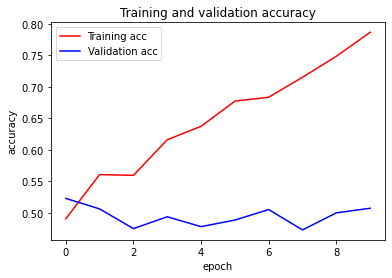

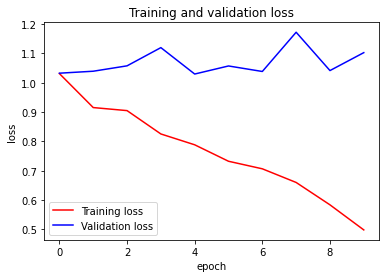

In [15]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.28      0.17      0.21       143
    Moderate       0.00      0.00      0.00        10
        None       0.67      0.68      0.68       512
   Very Mild       0.33      0.38      0.35       358

    accuracy                           0.50      1023
   macro avg       0.32      0.31      0.31      1023
weighted avg       0.49      0.50      0.49      1023

------------------------Confusion Matrix---------------------------


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

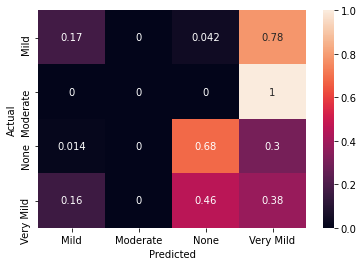

In [16]:
#Confution Matrix and Classification Report

Y_pred = model.predict_generator(val_generator, val_generator.n// batch_size+1) # so it lines up with the batches
y_pred = np.argmax(Y_pred, axis=1)
target_names = ['Mild','Moderate','None','Very Mild']
print('-----------------------Classification Report-------------------')
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
print('------------------------Confusion Matrix---------------------------')

conf = confusion_matrix(val_generator.classes, y_pred, normalize='true')
ax = sns.heatmap(conf, annot=True, xticklabels = target_names, yticklabels= target_names);
ax.set(xlabel='Predicted', ylabel='Actual')

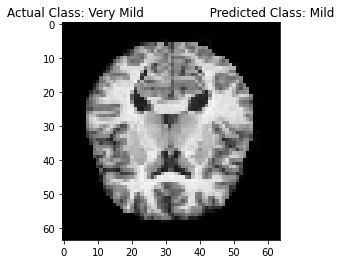

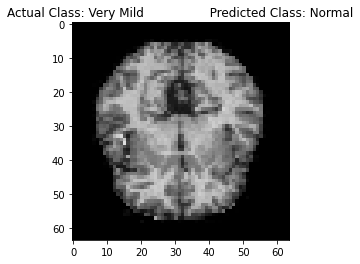

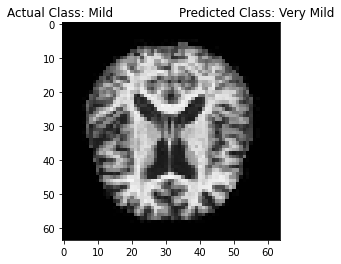

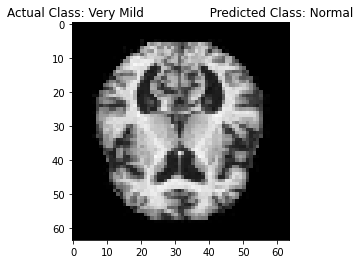

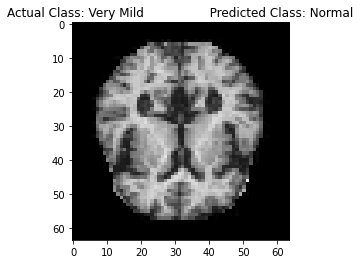

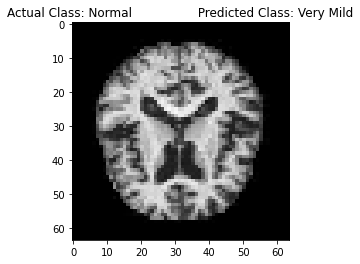

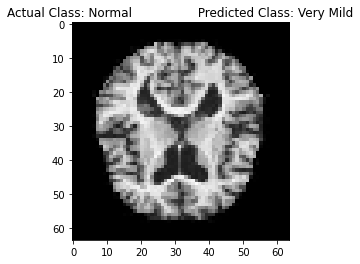

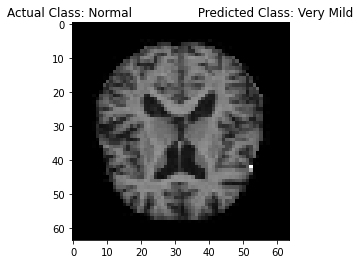

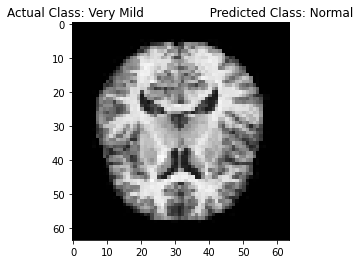

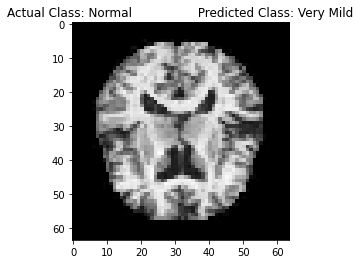

In [23]:
a = None
b = None 
j,k = val_generator[0]


# combing all the batches into one so we can see the images that were wrong
for i in range(1,val_generator.n// batch_size+1):
    a,b = val_generator[i]
    j = np.concatenate((a,j),0)
    
# the Indices of the labels that were incorrect    
incorrects = np.nonzero(y_pred != val_generator.classes)[0]     
    
# shows us a random assortment of what our model got wrong    
for i in np.random.choice(incorrects, 10):
    img = j[i]
    class_name = ['Mild', 'Moderate', 'Normal', 'Very Mild']
    act_classname = class_name[val_generator.classes[i]]
    pred_classname = class_name[y_pred[i]]
    
    plt.imshow(img)
    plt.title(f'Actual Class: {act_classname}\
                 Predicted Class: {pred_classname}')
    plt.show()

# Looking at the Activation Layers

In [24]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 10)        280       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 20)        1820      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 20)        3620      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

(1, 62, 62, 10)


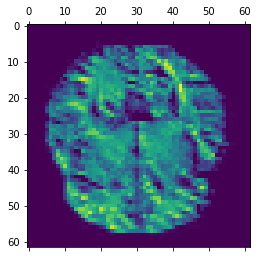

In [26]:
img_path = '../../src/data/train/NonDemented/nondem100.jpg'


img = image.load_img(img_path, target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)


activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]  #The first activation layer 
print(first_layer_activation.shape)

# We slice the 9th channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 9], cmap='viridis') # There are 10 different channels because our input was 10 for our first layer
plt.show()

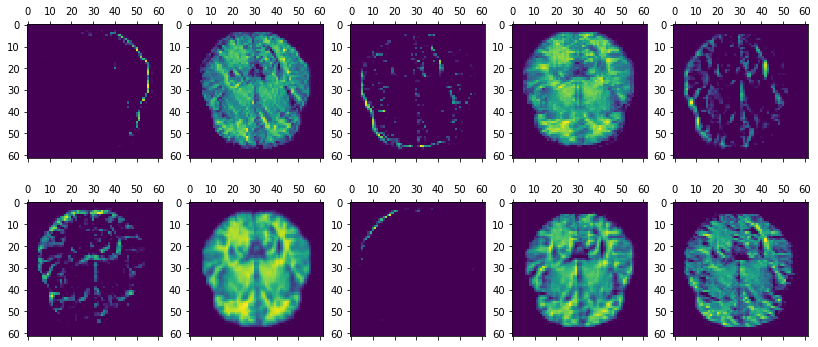

In [27]:
# All the different channels of the first imput layer. 
fig, axes = plt.subplots(2, 5, figsize=(14,6))
for i in range(10):
    row = i//5
    column = i%5
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

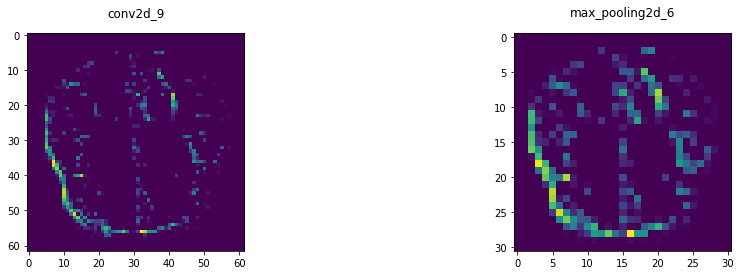

In [28]:
fig, axes = plt.subplots(1,2, figsize=(16,4))

layer_names = []
for layer in model.layers[:2]:
    layer_names.append(layer.name)

for i in range(2):
    column = i%4
    ax = axes[column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 2], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])